In [1]:
import sys
sys.path.append('/home/maria/Documents/projects/check/avs7_miniproject/')

#### **Poisson Blending**

This part will do the blending of a patch into a new image.

In [2]:
import numpy as np
from PIL import Image
import random
import scipy as sp


from constants import MVTEC, GAMMA_PARAMS, OBJECT_RESIZE_BOUNDS, TEXTURE_RESIZE_BOUNDS
from utils.visualization import *

We start where from the `outputs` of the `Patch Sampling` module. So we should first read the `src_mask`, the `src_image` and the `dest_image`.

In [3]:
DEST_IMAGE = '/home/maria/Documents/projects/avs7_miniproject/images/dest.png'
SRC_IMAGE = '/home/maria/Documents/projects/avs7_miniproject/images/src.png'
MASK = '/home/maria/Documents/projects/avs7_miniproject/images/mask.png'

In [4]:
def read_image(path_to_image: str, mask_image: bool, scale: bool=False):
    
    img = Image.open(path_to_image)

    if mask_image:
        img = img.convert("L") # greyscale
        binary_mask = np.array(img) > 127
        return binary_mask.astype(np.uint8)

    img = np.array(img.convert('RGB'))
    if scale:
        return img.astype('double') / 255.0

    return img

In [5]:
src_image = read_image(path_to_image=SRC_IMAGE, mask_image=False, scale=True)
dest_image = read_image(path_to_image=DEST_IMAGE, mask_image=False, scale=True)
mask = read_image(path_to_image=MASK, mask_image=True)

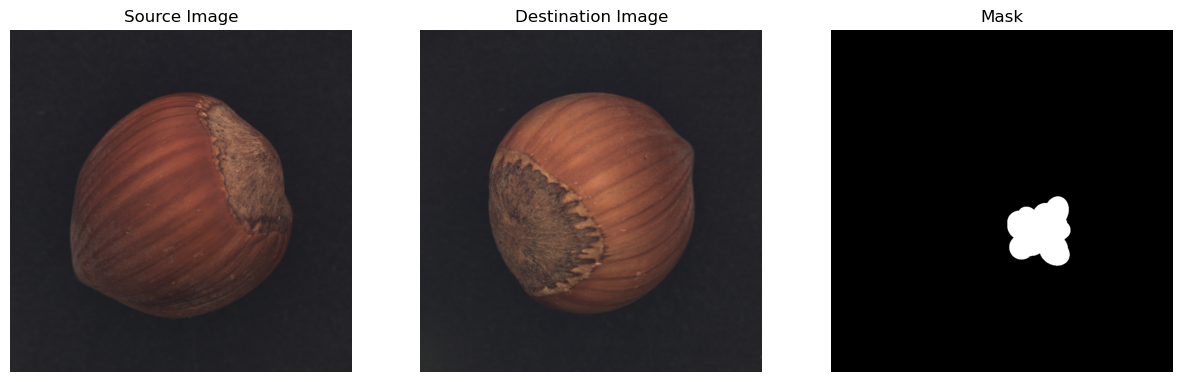

In [6]:
display_images_side_by_side(images=[src_image, dest_image, mask], titles=['Source Image', 'Destination Image', 'Mask'], config_cmap = [None, None, 'grey'])


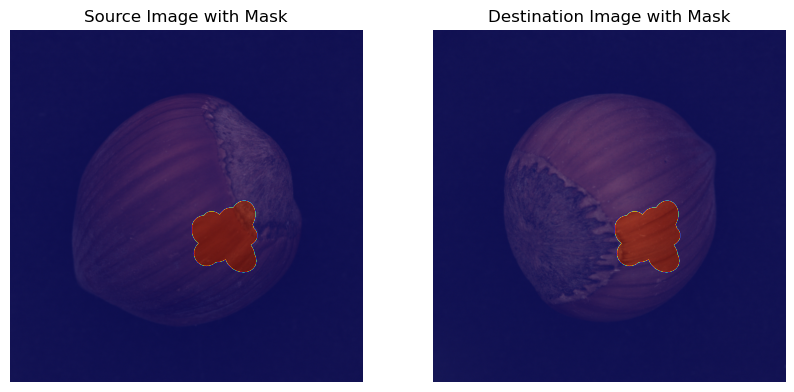

In [7]:
mask_on_top(image1=src_image, image2=dest_image, mask=mask, titles=["Source Image with Mask", "Destination Image with Mask"])

The method is applied per channel. So let's visualize the algorithm being performed in one single channel.

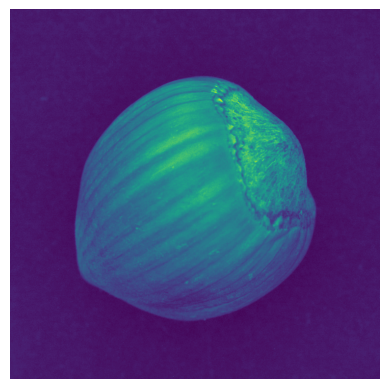

In [8]:
src_image_test = src_image[:,:,2]
dest_image_test = dest_image[:,:,2]
plt.imshow(src_image[:,:,0])
plt.axis('off')
plt.show()

In [9]:
H, W = src_image_test.shape
print(f'Size of the image is: H={H} x W={W}')

Size of the image is: H=1024 x W=1024


**Identify Masked Pixels:** After we need to compute the total number of pixels in the mask that have value **1**, which means, the total number of pixels that identifies the object - masked area. This value, represents the number of pixels in `src_mask`that are part of the blending region.

In [10]:
num_mask_pixels = mask.sum().astype(int)
print(f'Total number: {num_mask_pixels}')

Total number: 29317


After, we create a new array with the same shape as `src_mask`, filling it initially with -1. 

In [11]:
pixel_idx_map = np.full(mask.shape, -1, dtype=int)
pixel_idx_map

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

We then retrieve from the `src_mask` the coordinates of pixels with value 1.

In [12]:
y_coords, x_coords = np.where(mask == 1)
print(f'Number of pairs: {y_coords.shape[0]}')

Number of pairs: 29317


**Create Index Map:** Now, we assign a unique index from 0 to 3036 to each pixel where has value 1 in the `src_mask`. This unique index is linked to the coordinates retrieved on the above step. So, in index 0 we have the first pair of coordinates where the pixel has value 1.

In [13]:
pixel_idx_map[mask>0] = np.arange(num_mask_pixels)

**Initialize Sparse Matrix A:** Now, we create a sparse matrix **A**. The `4 * num_mask_pixels` represents the maximum number of equations, considering up to 4 neighbours per masked pixel. Initially the sparse matrix is filled with zeros.

In [14]:
A = sp.sparse.lil_matrix((4 * num_mask_pixels, num_mask_pixels))

print("The sparse matrix A:\n")
print(A.toarray())

The sparse matrix A:

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Initialize Vector b:** We also initialise the vecto `b` with zeros. This vector will store the constants for each equation in the blending process.

In [15]:
b = np.zeros(4 * num_mask_pixels)

print("The vector b: \n")
print(b)

The vector b: 

[0. 0. 0. ... 0. 0. 0.]


Up to this point we have initialized the structures needed to set up a linear systems of equations for Poisson blending. Now we need to populate both the sparse matrix `A` and the vector `b`. The paper [1] uses two ways: Through **NORMAL_CLONE** and **MIXED_CLONE**.

Both techniques can have good performance on blending an object from source image into target image, depending on which images they are used with.

The reason for this is that they differ in how they handle gradients during the blending process, which leads to different visual outcomes.


It's fundamental to how Poisson blending works to look at the the neighbours when populatin the sparse matrix `A`and vector `b` with gradient values. This ensures a smooth and natural transition between the source and target images.

For pixels on the edge of the mask, some of their 4-connected neighbours will fall outside the mask, and therefore belong to the target image. In this case the neighbour's value from the target image is add to the vector `b` as a boundary condition.

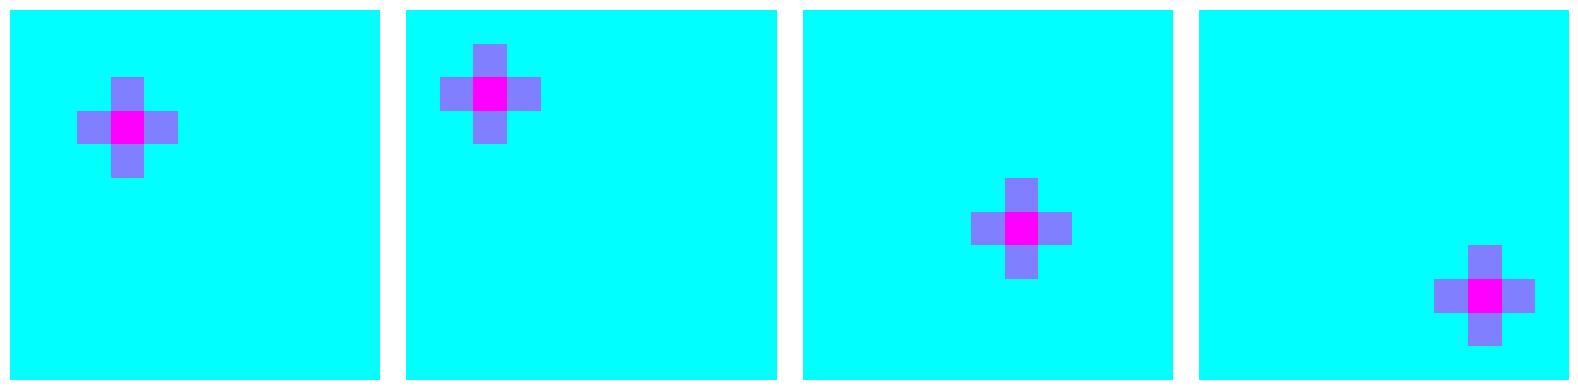

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

points = [(3, 3), (2, 2), (6, 6), (8, 8)]
max_i, max_j = 10, 10

for ax, (i, j) in zip(axes, points):
    visualize_neighbors(ax, i, j, max_i, max_j)
    ax.axis('off')
plt.tight_layout()
plt.show()

Now, let's undersdand the two options we have to populate the sparse matrix `A` and the vector `b`. 

With the **NORMAL_CLONE** the exact gradients from the source image are copied to the target image in the marked region. So these gradients within the source region defined by the mask are preserved. So normal cloning is effective when the source object’s lighting and texture match or are close to the target. So it is deal when the goal is to transfer an object to a similar background.

We initiate by looping through the total number of masked pixels, getting from `y_coord` and `x_coords` their location. After, we loop through the 4-connected neighbours, so for each neighbour (ny,nx) we populate an equantion based on their relationships.  

Then a coefficient of `1` is assigned to the center pixel (y,x) in the current equation, meaning that this pixel contributes to the equation.

After, we compute the difference between the center pixel (y,x) and its neighbour (ny, nx) in the image is stored in `b[counter]`.

Then we check if the neighbour:
-  is inside the mask: the neighbours coefficient is set to -1, indicating the difference in therms of gradient between the center and the neighbouring pixel within the masked region
- is outside the mask: the beighbour belongs to the target image. In this case, the intensity of the neighbour from the target image is added to `b[counter]`.

In [17]:
def populate_normal(A, b, y_coords, x_coords, pixel_idx_map, src_image_test, dest_image_test, H, W):

    counter = 0
    num_mask_pixels = len(y_coords)

    for index in range(num_mask_pixels):
        y, x = y_coords[index], x_coords[index]

        for ny, nx in get_neighbors(y, x, H-1, W-1):
            A[counter, pixel_idx_map[y][x]] = 1
            
            b[counter] = src_image_test[y][x] - src_image_test[ny][nx]

            if pixel_idx_map[ny][nx] != -1:
                A[counter, pixel_idx_map[ny][nx]] = -1
            else:
                b[counter] += dest_image_test[ny][nx]

            counter += 1
    
    return A, b

In [18]:
A, b = populate_normal(A, b, y_coords, x_coords, pixel_idx_map, src_image_test, dest_image_test, H, W)

In [19]:
print("The sparse matrix A:\n")
print(A.toarray())

The sparse matrix A:

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]]


In [20]:
print("The vector b: \n")
print(b)

The vector b: 

[ 0.21568627 -0.00392157  0.22352941 ...  0.22352941  0.
  0.20392157]


Then, we convert the sparce matrix to compressed sparse row, which was required due to memory issues. After we solve the linear system using the **least squares QR**. The solution `v` represents the values of the masked pixels that will blend smoothly between the source and the target images. 

Each element in `v` corresponds to a pixel intensity in the blended region, calculated with the goal of achieve a smooth transition based on the constraints set up in A and b.

In [21]:
A = sp.sparse.csr_matrix(A)
v = sp.sparse.linalg.lsqr(A, b)[0]

print(f"v:\n{v}\n")
print(f"Size of v:\n{len(v)}\n")

v:
[0.22594417 0.23142928 0.21910052 ... 0.20074483 0.20332636 0.20690998]

Size of v:
29317



In [22]:
copy_dest = dest_image_test.copy()

for index in range(num_mask_pixels):
    y, x = y_coords[index], x_coords[index]
    copy_dest[y][x] = v[pixel_idx_map[y][x]]

blended_channel2 = np.clip(copy_dest, 0, 1)

Now, joining all the steps, so we can generate for each channel:

In [23]:
def compute_poisson_blend_channel(src_image_test, dest_image_test, mask):

    H, W = src_image_test.shape

    num_mask_pixels = mask.sum().astype(int)
    pixel_idx_map = np.full(mask.shape, -1, dtype=int)
    y_coords, x_coords = np.where(mask == 1)
    pixel_idx_map[mask > 0] = np.arange(num_mask_pixels)

    A = sp.sparse.lil_matrix((4 * num_mask_pixels, num_mask_pixels))
    b = np.zeros(4 * num_mask_pixels)

    A, b = populate_normal(A, b, y_coords, x_coords, pixel_idx_map, src_image_test, dest_image_test, H, W)

    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]

    copy_dest = dest_image_test.copy()

    for index in range(num_mask_pixels):
        y, x = y_coords[index], x_coords[index]
        copy_dest[y][x] = v[pixel_idx_map[y][x]]

    
    return np.clip(copy_dest, 0, 1)

blend_img_normal = np.zeros(dest_image.shape)
blend_img_normal[:,:,0] = compute_poisson_blend_channel(src_image[:,:,0], dest_image[:,:,0], mask)
blend_img_normal[:,:,1] = compute_poisson_blend_channel(src_image[:,:,1], dest_image[:,:,1], mask)
blend_img_normal[:,:,2] = compute_poisson_blend_channel(src_image[:,:,2], dest_image[:,:,2], mask)

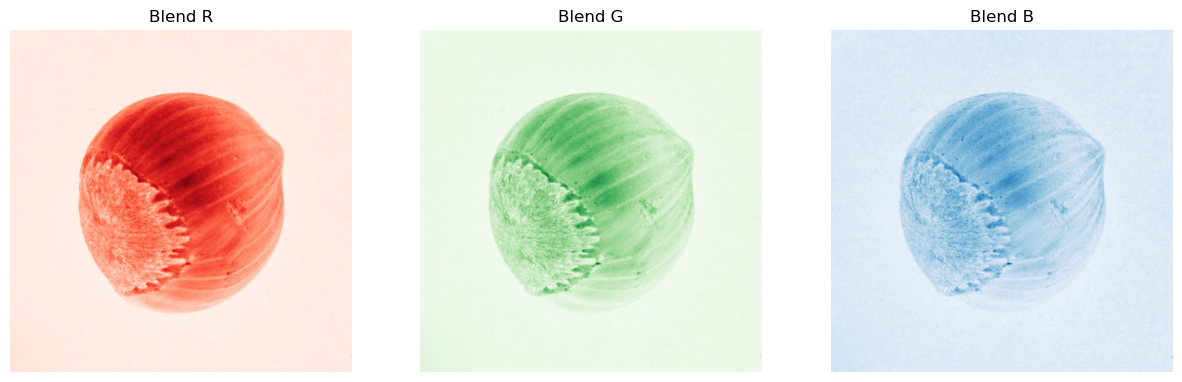

In [24]:
display_images_side_by_side(images=[blend_img_normal[:,:,0], blend_img_normal[:,:,1], blend_img_normal[:,:,2]], titles=['Blend R', 'Blend G', 'Blend B'], config_cmap = ['Reds', 'Greens', 'Blues'])


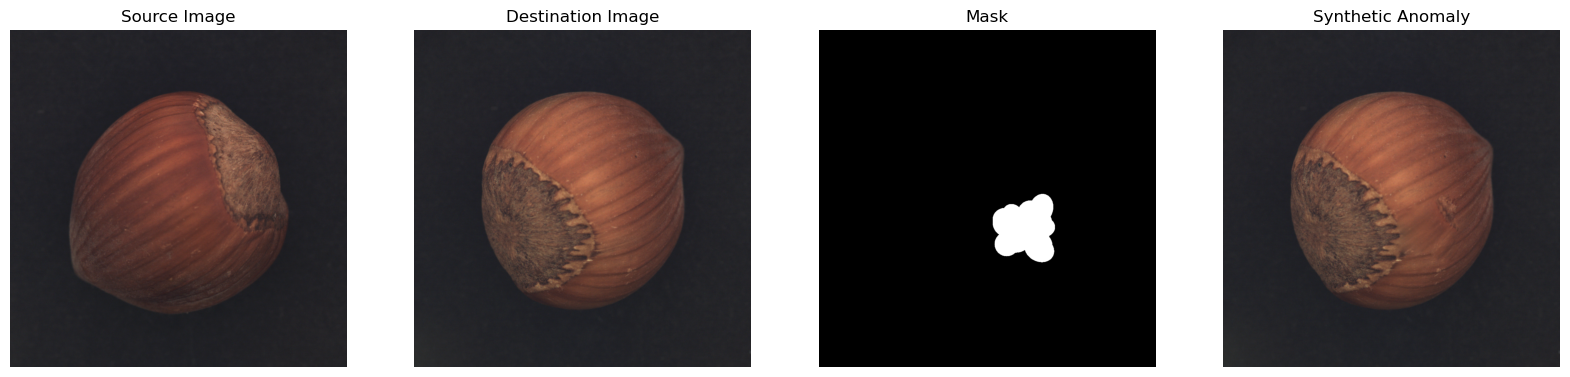

In [25]:
display_images_side_by_side(images=[src_image, dest_image, mask, blend_img_normal], titles=['Source Image', 'Destination Image', 'Mask', 'Synthetic Anomaly'], config_cmap = [None, None, 'grey', None])


With the **MIXED_CLONE** the pipeline is similar, but now a combination of gradients from both source and target imafes are performed. Instead of solely using the source's gradients, its pickes the strongest gradient, either from the source or target for each pixel.

In [26]:
def populate_mixed(A, b, y_coords, x_coords, pixel_idx_map, src_image_test, dest_image_test, H, W):

    counter = 0
    num_mask_pixels = len(y_coords)

    for index in range(num_mask_pixels):
        y, x = y_coords[index], x_coords[index]

        for ny, nx in get_neighbors(y, x, H-1, W-1):
            d1 = src_image_test[y][x] - src_image_test[ny][nx]
            d2 = dest_image_test[y][x] - dest_image_test[ny][nx]

            strongest = d1 if abs(d1) > abs(d2) else d2

            A[counter, pixel_idx_map[y][x]] = 1
            
            b[counter] = strongest

            if pixel_idx_map[ny][nx] != -1:
                A[counter, pixel_idx_map[ny][nx]] = -1
            else:
                b[counter] += dest_image_test[ny][nx]

            counter += 1
    
    return A, b

In [27]:
def compute_poisson_blend_channel(src_image_test, dest_image_test, mask):

    H, W = src_image_test.shape

    num_mask_pixels = mask.sum().astype(int)
    pixel_idx_map = np.full(mask.shape, -1, dtype=int)
    y_coords, x_coords = np.where(mask == 1)
    pixel_idx_map[mask > 0] = np.arange(num_mask_pixels)

    A = sp.sparse.lil_matrix((4 * num_mask_pixels, num_mask_pixels))
    b = np.zeros(4 * num_mask_pixels)

    A, b = populate_mixed(A, b, y_coords, x_coords, pixel_idx_map, src_image_test, dest_image_test, H, W)

    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]

    copy_dest = dest_image_test.copy()

    for index in range(num_mask_pixels):
        y, x = y_coords[index], x_coords[index]
        copy_dest[y][x] = v[pixel_idx_map[y][x]]

    
    return np.clip(copy_dest, 0, 1)

blend_img_mixed = np.zeros(dest_image.shape)
blend_img_mixed[:,:,0] = compute_poisson_blend_channel(src_image[:,:,0], dest_image[:,:,0], mask)
blend_img_mixed[:,:,1] = compute_poisson_blend_channel(src_image[:,:,1], dest_image[:,:,1], mask)
blend_img_mixed[:,:,2] = compute_poisson_blend_channel(src_image[:,:,2], dest_image[:,:,2], mask)

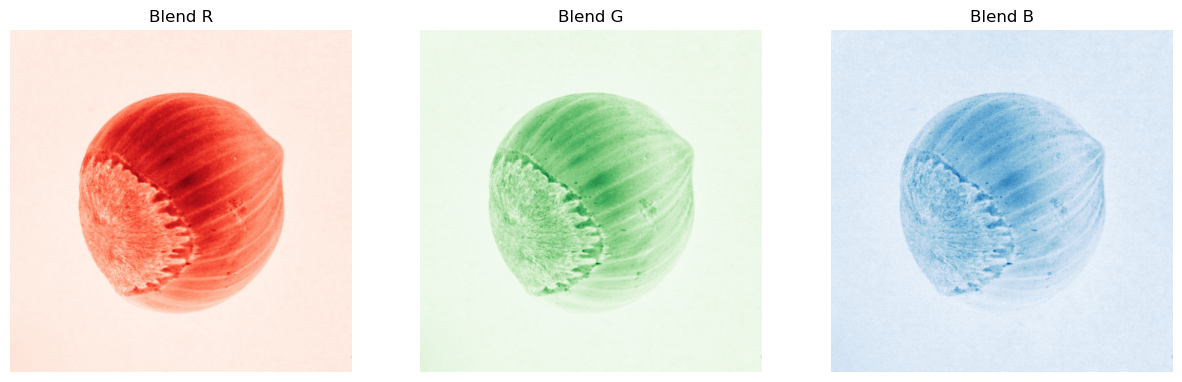

In [28]:
display_images_side_by_side(images=[blend_img_mixed[:,:,0], blend_img_mixed[:,:,1], blend_img_mixed[:,:,2]], titles=['Blend R', 'Blend G', 'Blend B'], config_cmap = ['Reds', 'Greens', 'Blues'])


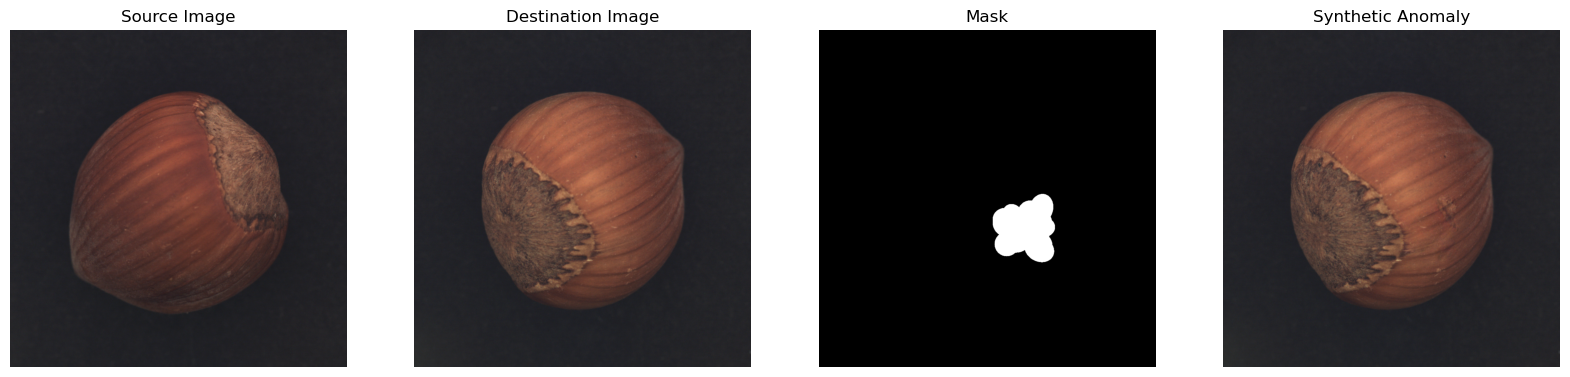

In [29]:
display_images_side_by_side(images=[src_image, dest_image, mask, blend_img_mixed], titles=['Source Image', 'Destination Image', 'Mask', 'Synthetic Anomaly'], config_cmap = [None, None, 'grey', None])


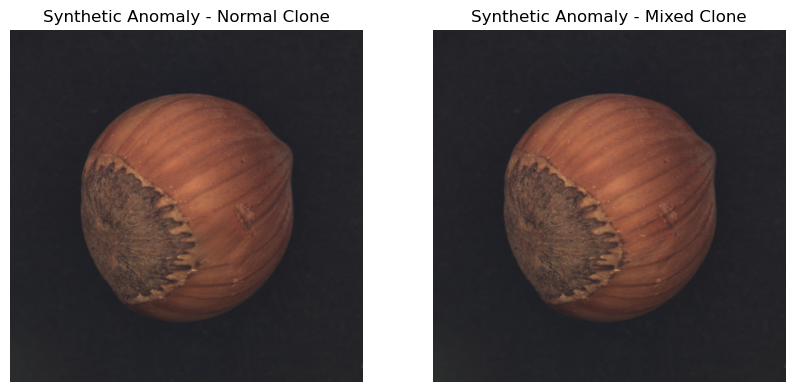

In [30]:
display_images_side_by_side(images=[blend_img_normal, blend_img_mixed], titles=['Synthetic Anomaly - Normal Clone', 'Synthetic Anomaly - Mixed Clone'], config_cmap = [None, None])


We can see that, as expected, the blending using the `MIXED_CLONE` is more smooth, because of the blending of gradients. Which also leads to a more transparent aspect. 